# LSTM model

## Architecture

Many-to-many

## DataSet implementation

- Index is ticker based (create dictionary)
- Analysis on padding



### Configuration parameters

In [1]:
TRANSFORMED_DATA_FN = "../data/transformed/data.csv" # Data
TRANSFORMED_META_FN = "../data/transformed/data.json" # Metadata

MAX_SEQ_LENGTH = 5

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import seaborn as sns

sns.set_style("whitegrid")

### Load data

In [3]:
df_1 = pd.read_csv(TRANSFORMED_DATA_FN)

In [4]:
# Convert datetimes

for col in ('calendardate', 'datekey', 'reportperiod', 'lastupdated'):
    df_1[col] = pd.to_datetime(df_1[col])

In [5]:
df_2 = df_1.sort_values(by=['ticker', 'datekey'])

In [6]:
df_2.head()

,ticker,exchange,siccode,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,...,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,price_shifted,pct_change_shifted,class1
0,A,NYSE,3826.0,ART,2014-03-31,2014-06-04,2014-04-30,2019-08-30,132000000.0,1.102600e+10,...,20.360,7.134000e+09,0.0,130000000.0,0.0,21.423,3.658000e+09,58.07,0.010792,0
1,A,NYSE,3826.0,ART,2014-06-30,2014-09-02,2014-07-31,2019-08-30,53000000.0,1.038000e+10,...,20.641,6.610000e+09,0.0,123000000.0,0.0,19.790,3.255000e+09,41.88,-0.278801,0
2,A,NYSE,3826.0,ART,2014-09-30,2014-12-22,2014-10-31,2019-08-30,-334000000.0,1.083100e+10,...,20.964,7.265000e+09,0.0,142000000.0,0.0,21.817,3.798000e+09,40.63,-0.029847,0
3,A,NYSE,3826.0,ART,2014-12-31,2015-03-10,2015-01-31,2019-08-30,-261000000.0,7.519000e+09,...,18.833,4.608000e+09,0.0,157000000.0,0.0,13.714,2.726000e+09,40.31,-0.007876,0
4,A,NYSE,3826.0,ART,2015-03-31,2015-06-05,2015-04-30,2019-08-30,-270000000.0,7.412000e+09,...,16.647,4.555000e+09,0.0,118000000.0,0.0,13.638,2.690000e+09,35.53,-0.118581,0


In [7]:
mask = (df_2['pct_change_shifted']>-0.3) & (df_2['pct_change_shifted']<0)
df_2.loc[mask,'class1'] = 1

In [8]:
mask = (df_2['pct_change_shifted']>0) & (df_2['pct_change_shifted']<0.3)
df_2.loc[mask,'class1'] = 2

In [9]:
mask = (df_2['pct_change_shifted']>0.3)
df_2.loc[mask,'class1'] = 3

In [10]:
#df_2.fillna(-1, inplace=True)

In [11]:
df_2.head()

,ticker,exchange,siccode,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,...,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,price_shifted,pct_change_shifted,class1
0,A,NYSE,3826.0,ART,2014-03-31,2014-06-04,2014-04-30,2019-08-30,132000000.0,1.102600e+10,...,20.360,7.134000e+09,0.0,130000000.0,0.0,21.423,3.658000e+09,58.07,0.010792,2
1,A,NYSE,3826.0,ART,2014-06-30,2014-09-02,2014-07-31,2019-08-30,53000000.0,1.038000e+10,...,20.641,6.610000e+09,0.0,123000000.0,0.0,19.790,3.255000e+09,41.88,-0.278801,1
2,A,NYSE,3826.0,ART,2014-09-30,2014-12-22,2014-10-31,2019-08-30,-334000000.0,1.083100e+10,...,20.964,7.265000e+09,0.0,142000000.0,0.0,21.817,3.798000e+09,40.63,-0.029847,1
3,A,NYSE,3826.0,ART,2014-12-31,2015-03-10,2015-01-31,2019-08-30,-261000000.0,7.519000e+09,...,18.833,4.608000e+09,0.0,157000000.0,0.0,13.714,2.726000e+09,40.31,-0.007876,1
4,A,NYSE,3826.0,ART,2015-03-31,2015-06-05,2015-04-30,2019-08-30,-270000000.0,7.412000e+09,...,16.647,4.555000e+09,0.0,118000000.0,0.0,13.638,2.690000e+09,35.53,-0.118581,1


In [12]:
#filter_mask = (df_2['marketcap']>1000000.0) & (df_2['netmargin'] > -0.5)

In [13]:
#df_2 = df_2.loc[filter_mask,:]

In [14]:
# Break down the temporal chains

tickers = df_2['ticker'].values
max_count = MAX_SEQ_LENGTH

prev_ticker = tickers[0]
output_tickers = [prev_ticker+"_0"]
counter = 0
append_index = 0

for ticker in tickers[1:]:
    if ticker == prev_ticker:
        counter +=1        
    else:
        counter = 0
        append_index = 0
    if counter == max_count:
        counter = 0
        append_index +=1
    output_tickers.append(ticker+"_{}".format(append_index))
    prev_ticker = ticker
    
assert len(output_tickers) == len(tickers)
output_tickers[:22]
tickers[:22]

df_2['ticker'] = output_tickers

In [15]:
with open(TRANSFORMED_META_FN, 'r') as fp:
    metadata = json.load(fp)
    
features = metadata['features'].split(",")
target = metadata['target']
#target='pct_change_shifted'

In [16]:
features = [ 'assets', 'assetsavg', 'assetsc',
       'assetsnc', 'assetturnover', 'bvps', 'capex', 'cashneq',
       'cashnequsd', 'cor', 'consolinc', 'currentratio', 'de', 'debt',
       'debtc', 'debtnc', 'debtusd', 'deferredrev', 'depamor', 'deposits',
       'divyield', 'dps', 'ebit', 'ebitda', 'ebitdamargin', 'ebitdausd',
       'ebitusd', 'ebt', 'eps', 'epsdil', 'epsusd', 'equity', 'equityavg',
       'equityusd', 'ev', 'evebit', 'evebitda', 'fcf', 'fcfps', 'fxusd',
       'gp', 'grossmargin', 'intangibles', 'intexp', 'invcap',
       'invcapavg', 'inventory', 'investments', 'investmentsc',
       'investmentsnc', 'liabilities', 'liabilitiesc', 'liabilitiesnc',
       'marketcap', 'ncf', 'ncfbus', 'ncfcommon', 'ncfdebt', 'ncfdiv',
       'ncff', 'ncfi', 'ncfinv', 'ncfo', 'ncfx', 'netinc', 'netinccmn',
       'netinccmnusd', 'netincdis', 'netincnci', 'netmargin', 'opex',
       'opinc', 'payables', 'payoutratio', 'pb', 'pe', 'pe1', 'ppnenet',
       'prefdivis', 'price', 'ps', 'ps1', 'receivables', 'retearn',
       'revenue', 'revenueusd', 'rnd', 'roa', 'roe', 'roic', 'ros',
       'sbcomp', 'sgna', 'sharefactor', 'sharesbas', 'shareswa',
       'shareswadil', 'sps', 'tangibles', 'taxassets', 'taxexp',
       'taxliabilities', 'tbvps', 'workingcapital']

In [17]:
seq_lengths = df_2.groupby('ticker').count()['datekey'].values


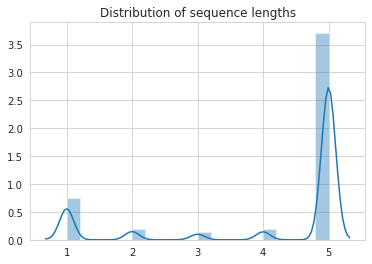

In [18]:
sns.distplot(seq_lengths, bins = 20);
plt.title("Distribution of sequence lengths");

In [19]:
max(seq_lengths)

5

In [20]:
print("Maximum sequence length: ", max(seq_lengths))

Maximum sequence length:  5


In [21]:
def get_padded_features(sorted_df, ticker, features, target, n_pad):
    """ Return padded features and target
    
    Arguments
    ---------
    
    sorted_df : Pandas dataframe
        Dataframe with indicators, sorted by ticker and datekey        
    ticker : str
        Ticker name
    features : list
        Feature names        
    target : str
        Target name
    pad : int
        Pad length
    
    Returns
    -------
    padded_features : ndarray with shape (n_pad, n_features)
    target : ndarray with shape (n_pad,1)
    
    """
    
    n_features = len(features)
    
    ticker_data = sorted_df.loc[sorted_df['ticker'] == ticker, :]
    
    ticker_features = ticker_data.loc[:, features]
    ticker_target = ticker_data.loc[:, target]
    
    out_features = np.zeros((n_pad, n_features))
    out_target = np.zeros((n_pad, 1))
    
    out_features[0:len(ticker_features)] = ticker_features.values
    out_target[0:len(ticker_features)] = ticker_target.values.reshape(-1,1)
    
    return out_features, out_target, len(ticker_features)

In [22]:
feat_array, target_array, len_ticker = get_padded_features(df_2, ticker='GEN', features = features, target = target, n_pad = MAX_SEQ_LENGTH)

In [23]:
feat_array.shape, target_array.shape

((5, 104), (5, 1))

### Prepare data

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
# Create unique ticker list and shuffle

all_tickers = df_2['ticker'].unique()
np.random.shuffle(all_tickers)

In [26]:
len(df_2['ticker'].unique())

20447

In [27]:
class TickersIndicatorsDataset(Dataset):
    """
    Tickers Indicators Dataset
    
    """
    def __init__(self, indicators_df, feature_names, target_name, n_pad):
        
        self.df = indicators_df.sort_values(by=['ticker', 'datekey'])
        self.target = target_name
        self.features = feature_names
        self.ticker_list = self.df['ticker'].unique()
        self.n_pad = n_pad
        
    def __len__(self):
        return len(self.ticker_list)
    
    def __getitem__(self, idx):
        
        ticker = self.ticker_list[idx]
        X, y, len_ticker = get_padded_features(self.df, ticker=ticker, features = self.features, target = self.target, n_pad = self.n_pad)
        
        return torch.from_numpy(X).float(),  torch.tensor(y, dtype=torch.long), len_ticker

In [28]:
td = TickersIndicatorsDataset(df_2, features, target, MAX_SEQ_LENGTH )

In [29]:
len(td)

20447

### Pre-processing

Scaling and imputation

In [30]:

from sklearn import preprocessing
from sklearn.preprocessing import Imputer

In [31]:
test_ratio = 0.5

test_idx = int(len(all_tickers)*test_ratio)
test_idx = 3000

In [32]:
train_tickers = all_tickers[:test_idx]
test_tickers = all_tickers[test_idx:test_idx+test_idx]

In [33]:
df_train_all = df_2[df_2['ticker'].isin(train_tickers)]
df_test_all = df_2[df_2['ticker'].isin(test_tickers)]

df_train = df_train_all[features]
df_test = df_test_all[features]

In [34]:
# Imputation

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(df_train)

df_train_imp = pd.DataFrame(imputer.transform(df_train))
df_train_imp.columns = df_train.columns
df_train_imp.index = df_train.index

df_test_imp = pd.DataFrame(imputer.transform(df_test))
df_test_imp.columns = df_test.columns
df_test_imp.index = df_test.index

In [35]:
imputer

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [36]:
# Scaler

scaler = preprocessing.StandardScaler().fit(df_train_imp)

cols, idx = df_train_imp.columns, df_train_imp.index
df_train_imp = pd.DataFrame(scaler.transform(df_train_imp))
df_train_imp.columns = cols
df_train_imp.index = idx

cols, idx = df_test_imp.columns, df_test_imp.index
df_test_imp = pd.DataFrame(scaler.transform(df_test_imp))
df_test_imp.columns = cols
df_test_imp.index = idx

In [37]:
meta_cols = ['ticker', 'datekey',target]

df_train_imp[meta_cols] = df_train_all[meta_cols]
df_test_imp[meta_cols] = df_test_all[meta_cols]

In [38]:
df_train_imp.describe()

,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,...,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,class1
count,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,...,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,1.252700e+04,12527.000000
mean,9.142922e-18,-2.640956e-17,3.605987e-18,-3.337892e-18,-7.357764e-17,-1.173497e-17,-6.821464e-18,5.166809e-17,6.144358e-17,5.683883e-16,...,-2.692360e-17,2.636636e-18,2.195539e-17,-9.077782e-17,1.904942e-16,-1.063157e-16,-1.610238e-15,-2.928438e-17,4.793830e-17,1.506745
std,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,...,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,0.720427
min,-4.031922e-02,-4.188254e-02,-4.183075e-02,-3.456286e-02,-4.409906e+01,-9.423111e+01,-7.462565e+01,-3.407888e-02,-8.291321e-02,-2.967368e-02,...,-6.721799e-02,-2.452663e-01,-1.159258e-02,-4.003073e-02,-1.996163e-02,-3.088744e+00,-2.596530e-02,-1.574366e-02,-1.116913e+01,0.000000
25%,-4.029610e-02,-4.185666e-02,-4.157976e-02,-3.451255e-02,-5.196942e-01,1.450664e-02,2.497343e-02,-3.406511e-02,-8.162972e-02,-2.935523e-02,...,-6.202273e-02,-2.019159e-01,-1.157782e-02,-4.001173e-02,-1.996163e-02,-2.520840e-02,-2.596510e-02,-1.574337e-02,-2.878820e-02,1.000000
50%,-4.020380e-02,-4.175358e-02,-4.058244e-02,-3.396732e-02,-1.259239e-01,1.450676e-02,2.554440e-02,-3.402900e-02,-7.826818e-02,-2.909112e-02,...,-5.461155e-02,-1.209156e-01,-1.157585e-02,-3.994424e-02,-1.996163e-02,-2.515613e-02,-2.596484e-02,-1.574282e-02,-2.705252e-02,2.000000
75%,-3.987770e-02,-4.134727e-02,-5.011124e-03,-1.128701e-02,2.523866e-01,1.450692e-02,2.562659e-02,-3.389949e-02,-6.639468e-02,-2.744218e-02,...,-3.613819e-02,5.399332e-17,-1.157011e-02,-3.969012e-02,-1.984570e-02,-2.465079e-02,-2.559589e-02,-1.574151e-02,0.000000e+00,2.000000
max,4.460924e+01,4.299224e+01,5.395607e+01,5.926413e+01,1.704355e+01,1.603162e-02,4.332681e-02,5.560172e+01,4.713711e+01,5.908483e+01,...,1.038376e+02,7.424648e+01,1.087047e+02,4.450874e+01,9.244794e+01,6.966516e+01,8.777293e+01,7.256569e+01,7.105251e+01,3.000000


In [39]:
df_train_imp.shape

(12527, 107)

## LSTM Model

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [41]:
class Model(nn.Module):
    
    def __init__(self, feature_size, n_activation = 15):
        super(Model, self).__init__()
        
        self.n_activation = n_activation
        
        # LSTM parameters - input feature size X, number of units in hidden layer.
        
        self.lstm = nn.LSTM(feature_size, n_activation, batch_first=True)
        self.linear2 = nn.Linear(n_activation, 5)
        self.out = nn.Linear(5, 1)
        self.out2 = nn.Linear(n_activation, 4)
    
    def forward(self, x, lenx):
        
        # x has dimension of [batch_size, sequence size]       
        
        # Here h_lstm contains hidden activations from all sequences, dimension: [batch_size, seq_size, n_activation]
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, batch_first=True, lengths=lenx, enforce_sorted=False)
        
        h_lstm, (h_n, c_n) = self.lstm(x_packed)
        #layer2 = torch.relu(self.linear2(h_lstm))
        #out = self.out2(h_lstm)
        padded_output, output_lens = torch.nn.utils.rnn.pad_packed_sequence(h_lstm, batch_first=True, total_length=MAX_SEQ_LENGTH)
#         layer2 = torch.relu(self.linear2(padded_output))
        #out = torch.sigmoid(self.out2(padded_output))
        out = self.out2(padded_output)
        
        return out

In [42]:
df_train_imp.shape[0]

12527

In [43]:
model = Model(feature_size=df_train.shape[1]).cpu()

In [44]:
learning_rate = 0.001
weight_decay=0.00001
batch_size = 200
n_epoch = 200

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [45]:
x_train = TickersIndicatorsDataset(df_train_imp, features, target, MAX_SEQ_LENGTH )
x_test = TickersIndicatorsDataset(df_test_imp, features, target, MAX_SEQ_LENGTH )

In [46]:
train_loader = DataLoader(x_train, batch_size=batch_size)

In [47]:
test_loader = DataLoader(x_test, batch_size=len(x_test))

In [48]:
# ### DEBUG test

# sample_data, sample_target, lenx = next(iter(train_loader))

# print(sample_data.shape, sample_target.shape)

# # Feed sample data
# out = model(sample_data.float(), lenx)

# out.shape

# sample_data.shape

# sample_target.shape

# #out.view(batch_size,-1).shape

# sample_target.view(-1, 1).shape

# loss = loss_function(out, sample_target.view(batch_size, -1))
# print(loss)


In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
# def calc_auc(model, dataloader):
#     model.eval()
#     roc_list = []
#     for data_i, target_i, len_i in dataloader:
#         y_pred = model(data_i, len_i).detach().squeeze().reshape(-1,1).numpy()
#         y_true = target_i.detach().squeeze().reshape(-1,1).numpy()
#         roc_list.append(roc_auc_score(y_true, y_pred))
#     return np.average(roc_list)


In [51]:
# def calc_loss(output_padded, y):
#     batch_ce_loss = 0.0
#     for i in range(output_padded.size(0)):
#       ce_loss = F.binary_cross_entropy(output_padded[i], y[i].view(-1,4), reduction="sum")
#       batch_ce_loss += ce_loss
#     return batch_ce_loss

In [52]:
train_loss, valid_loss = [], []
for i, epoch in enumerate(range(n_epoch)):

    model.train()
    for data_i, target_i, len_i in train_loader:
        
        optimizer.zero_grad()
        
        output = model(data_i, len_i)
     #   print(output.shape, target_i.view(-1,4).shape)
        loss = loss_function(output.permute(0,2,1), target_i.view(output.shape[0], -1))  
#         loss = calc_loss(output, target_i.view(-1,4)) 
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    #auc_train = calc_auc(model, train_loader)


    acc = 0
    model.eval()
    for data_i, target_i, len_i in test_loader:
        output = model(data_i, len_i)
        loss2 = loss_function(output.permute(0,2,1), target_i.view(output.shape[0], -1)) 
        #loss2 = calc_loss(output, target_i) 
        valid_loss.append(loss2.item())
        _, preds_tensor = torch.max(output.permute(0,2,1), 1)
        preds = np.squeeze(preds_tensor.numpy())
        acc +=np.average(target_i.numpy().reshape(-1,MAX_SEQ_LENGTH) == preds) # Here 4
    
   # auc_test = calc_auc(model, test_loader)
    acc = acc/len(test_loader)
    print("Epoch: {}, Train loss: {}, Validation loss: {}, Validation acc: {}".format(i,train_loss[-1], valid_loss[-1], acc))

Epoch: 0, Train loss: 1.425561547279358, Validation loss: 1.4192315340042114, Validation acc: 0.08293333333333333
Epoch: 1, Train loss: 1.385451316833496, Validation loss: 1.3806986808776855, Validation acc: 0.29873333333333335
Epoch: 2, Train loss: 1.3411930799484253, Validation loss: 1.337923526763916, Validation acc: 0.3702
Epoch: 3, Train loss: 1.2917449474334717, Validation loss: 1.2901521921157837, Validation acc: 0.37646666666666667
Epoch: 4, Train loss: 1.2434983253479004, Validation loss: 1.2442094087600708, Validation acc: 0.3784
Epoch: 5, Train loss: 1.2042781114578247, Validation loss: 1.2068440914154053, Validation acc: 0.3794666666666667
Epoch: 6, Train loss: 1.17709481716156, Validation loss: 1.1807734966278076, Validation acc: 0.3812
Epoch: 7, Train loss: 1.1613812446594238, Validation loss: 1.164945125579834, Validation acc: 0.3848
Epoch: 8, Train loss: 1.1509822607040405, Validation loss: 1.1533653736114502, Validation acc: 0.3924
Epoch: 9, Train loss: 1.1420507431030

In [67]:
preds_tensor

tensor([[2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [1, 1, 2, 2, 1],
        ...,
        [2, 2, 2, 2, 2],
        [2, 1, 1, 2, 2],
        [2, 1, 1, 1, 1]])

In [68]:
output = F.softmax(output, dim=1)

In [69]:
test_loader2 = DataLoader(x_test, batch_size=len(x_test))

In [70]:
model.eval()
for data_i, target_i, len_i in test_loader2:
    out1 = model(data_i, len_i)
    tar1 = target_i

In [71]:
pred = F.softmax(out1, dim=2).detach().squeeze().numpy()
tar = target_i.detach().squeeze().numpy()



In [72]:
filtered_pred = []
filtered_truth = []
for i, pred_i in enumerate(pred):
    filtered_pred += list(pred_i[:len_i[i]])

for i, tar_i in enumerate(tar):
    filtered_truth += list(tar_i[:len_i[i]])  
filtered_pred = np.array(filtered_pred)
filtered_truth = np.array(filtered_truth)

In [73]:
len(filtered_pred), len(filtered_truth)

(12602, 12602)

In [74]:
filtered_pred.shape

(12602, 4)

In [75]:
filtered_truth.shape

(12602,)

In [76]:
def extract_col(sorted_df, ticker, col):      
    ticker_data = sorted_df.loc[sorted_df['ticker'] == ticker, :]    
    df_col = ticker_data.loc[:, col]    
    return list(df_col.values)

In [77]:
pct_shifted = []

for ticker in test_tickers:
    pct_shifted = pct_shifted + extract_col(df_test_all, ticker, 'pct_change_shifted')
    
pct_shifted = np.array(pct_shifted)

In [78]:
len(pct_shifted)

12602

In [79]:
market_cap, net_margin, date_key = [], [], []

for ticker in test_tickers:
    market_cap = market_cap + extract_col(df_test_all, ticker, 'marketcap')
    net_margin = net_margin + extract_col(df_test_all, ticker, 'netmargin')
    date_key = date_key + extract_col(df_test_all, ticker, 'datekey')

In [80]:
market_cap = np.array(market_cap)
net_margin = np.array(net_margin)

In [81]:
date_key = np.array(date_key)

In [85]:
mask_recent = date_key>np.datetime64('2018-01-01')

In [86]:
#mask_recent 

In [87]:
np.average(mask_recent)

0.2857482939215997

In [88]:
mask_risky = (market_cap>1e6)

/home/snexus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [89]:
filtered_pred

array([[0.03020526, 0.42202592, 0.49487323, 0.0528956 ],
       [0.02055642, 0.4618836 , 0.4750381 , 0.04252192],
       [0.00774341, 0.41148365, 0.55700547, 0.02376739],
       ...,
       [0.24803805, 0.42570543, 0.23502232, 0.09123426],
       [0.27804086, 0.40122643, 0.21338484, 0.10734784],
       [0.31298637, 0.36909035, 0.23697874, 0.08094449]], dtype=float32)

In [90]:
sorted_pred = np.argsort(filtered_pred)

In [91]:
sorted_pred

array([[0, 3, 1, 2],
       [0, 3, 1, 2],
       [0, 3, 1, 2],
       ...,
       [3, 2, 0, 1],
       [3, 2, 0, 1],
       [3, 2, 0, 1]])

In [92]:
select_shares1 = ((sorted_pred[:,-1]==2) | (sorted_pred[:,-1]==3)) & ((filtered_pred[:,-1])>0.17)

In [93]:
select_shares2 = ((sorted_pred[:,-1]==3) & (sorted_pred[:,-2]==2)) & (filtered_pred[:,0]<0.3)

In [94]:
select_shares2

array([False, False, False, ..., False, False, False])

In [95]:
filtered_pred

array([[0.03020526, 0.42202592, 0.49487323, 0.0528956 ],
       [0.02055642, 0.4618836 , 0.4750381 , 0.04252192],
       [0.00774341, 0.41148365, 0.55700547, 0.02376739],
       ...,
       [0.24803805, 0.42570543, 0.23502232, 0.09123426],
       [0.27804086, 0.40122643, 0.21338484, 0.10734784],
       [0.31298637, 0.36909035, 0.23697874, 0.08094449]], dtype=float32)

In [122]:
select_shares3 =(filtered_pred[:,2]/filtered_pred[:,1] > 3) & mask_risky

In [123]:
select_shares4 = ((filtered_pred[:,3]+filtered_pred[:,2])>0.8)  &mask_risky

In [124]:
shares1 = pct_shifted[select_shares1]
shares2 = pct_shifted[select_shares2]
shares3 = pct_shifted[select_shares3]
shares4 = pct_shifted[select_shares4]

In [135]:
filtered_pred[select_shares3]

array([[1.19095363e-04, 2.40206763e-01, 7.56365359e-01, 3.30871739e-03],
       [7.23034842e-04, 2.25128070e-01, 7.61616588e-01, 1.25323376e-02],
       [6.73954724e-04, 1.94854707e-01, 7.90443003e-01, 1.40282838e-02],
       [4.79672308e-04, 1.65143818e-01, 8.24505746e-01, 9.87078436e-03],
       [1.18252169e-03, 2.14369729e-01, 7.75791943e-01, 8.65578093e-03],
       [3.15184792e-04, 1.52856231e-01, 8.41023266e-01, 5.80532942e-03],
       [2.03032047e-04, 1.28667802e-01, 8.65833223e-01, 5.29589504e-03],
       [1.93577303e-04, 1.19213812e-01, 8.74929488e-01, 5.66302845e-03],
       [2.21937872e-03, 2.38697320e-01, 7.48078108e-01, 1.10052517e-02],
       [2.60632252e-03, 2.33888924e-01, 7.52127528e-01, 1.13772312e-02],
       [2.15380918e-03, 2.03901738e-01, 7.73866236e-01, 2.00782083e-02],
       [1.72653364e-03, 1.65464967e-01, 8.06914389e-01, 2.58939862e-02],
       [1.48369919e-03, 1.45108595e-01, 8.25488865e-01, 2.79188566e-02],
       [8.37211777e-03, 2.38504380e-01, 7.33842969e

In [125]:
len(shares2), len(shares1), len(shares3), len(shares4), len(pct_shifted)

(9, 115, 140, 36, 12602)

In [126]:
np.average(shares2)

0.09433858467995113

In [127]:
np.average(pct_shifted)

0.01329217338511605

In [128]:
sell_threshold = -0.15

In [129]:
shares3[shares3<sell_threshold] = sell_threshold

In [130]:
shares1[shares1<sell_threshold] = sell_threshold

In [131]:
np.average(shares1)

0.026482587606040837

In [132]:
np.average(shares3)

0.05992798820539029

In [133]:
shares4[shares4<sell_threshold] = sell_threshold

In [134]:
np.average(shares4)

0.07442643375648093

In [109]:
shares4

array([ 1.43478261e-01,  6.06463878e-01,  1.88000000e-01, -1.50000000e-01,
        2.17430368e-01, -1.12177122e-01, -6.53384949e-02,  8.09813983e-03,
       -5.51181102e-02,  2.22297070e-01,  3.74531835e-03,  1.24122037e-01,
       -5.36952065e-03,  1.21711818e-02,  7.16220283e-02,  2.49605885e-02,
        1.20481928e-02, -1.34746180e-01,  1.50603782e-01,  2.89108911e-02,
       -2.96381832e-02,  2.12014134e-02,  1.24567474e-02,  1.17132867e-01,
       -1.50000000e-01, -1.50000000e-01, -5.93505039e-02, -4.88095238e-02,
        8.07748538e-02, -1.50000000e-01, -7.54716981e-02, -5.52220888e-02,
        5.04023719e-02,  7.75193798e-02, -5.99520384e-02,  5.21100917e-01,
        5.76598311e-01, -1.50000000e-01,  2.42712671e-01,  1.02262163e-01,
        2.54990160e-01,  1.06503512e-02, -1.97044335e-02,  8.54271357e-02,
       -1.50000000e-01, -1.02083333e-01, -1.50000000e-01,  2.63157895e-01,
       -1.50000000e-01, -3.01659125e-02, -1.02643857e-01,  1.36033229e-01,
        2.12065814e-01,  

In [ ]:
np.average(pct_shifted)

In [ ]:
mask=select_shares3

In [ ]:
len(filtered_pred[mask]), len(pct_shifted[mask])

In [ ]:
ax, fig = plt.subplots(figsize=(16,12))
plt.scatter(filtered_pred[mask, -1]+filtered_pred[mask, -2],  shares3, alpha=0.3)

In [ ]:
plt.hist(shares3, bins=20)

In [ ]:
sorted_pred

In [ ]:
#mask = (market_cap>1000000.0) & (net_margin > -0.5) & (filtered_pred>0.3)
mask = (filtered_pred>0.12)

In [ ]:
np.sum(mask)

In [ ]:
len(filtered_pred[mask])

In [ ]:
np.average(pct_shifted[mask])

In [ ]:
ax, fig = plt.subplots(figsize=(16,12))
plt.scatter(filtered_pred[mask], pct_shifted[mask], alpha=0.3)

In [ ]:
out1.shape

In [ ]:
pred = out1.detach().squeeze().reshape(-1,1).numpy()

In [ ]:
target_1  = tar1.detach().squeeze().reshape(-1,1).numpy()

In [ ]:
pred

In [ ]:
target_1

In [ ]:
plt.hist(pred, bins = 20)

In [ ]:
plt.scatter(pred, target_1, )

In [ ]:
len(pct_shifted)

In [ ]:
len(target_1)

In [ ]:
extract_col(df_test_all, 'TGNA_2', 'pct_change_shifted')

In [ ]:
roc_auc_score(target_1, pred)

In [ ]:
i=15
out1[i], tar1[i]

In [ ]:
tar1[5]

In [ ]:
out1.squeeze().detach().numpy()

In [ ]:
tar1.squeeze().numpy()

In [ ]:
tar1.shape

In [ ]:
out1.squeeze().detach().numpy()[99]

In [ ]:
data_i.shape